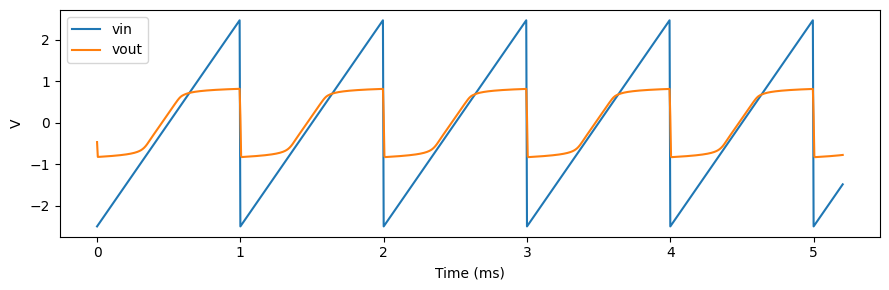

In [61]:
# Local per-node solves; BE companions use (·_i - ·_p); no guesses beyond carried predictors.
import numpy as np, matplotlib.pyplot as plt

fs=192_000.0; dt=1/fs; N=1000
R1,C1 = 1_00.0, 10e-6
R2,C2 = 100_000.0, 4.7e-9
Is,n,Vt = 2e-9,2.0,25.85e-3
nVt=n*Vt; Gc1=C1/dt; Gc2=C2/dt

t=np.arange(N)/fs
vin=2.5*(2*((t*1_000.0)%1)-1.0)

vm=np.zeros(N); vo=np.zeros(N)
# state: previous (p) and current/predicted (i)
vm_p=vo_p=0.0
vm_i=vo_i=0.0   # carried across samples and used in (·_i - ·_p)

def d_lin(v):
    x=v/nVt; I=2*Is*np.sinh(x); g=(2*Is/nVt)*np.cosh(x)
    i_off = I - g*v
    return g,i_off

for k in range(N):
    # linearize diodes at current predictor vo_i (consistent use of “i”)
    for iter in range(40):
        gD,i_off = d_lin(vo_i)

        # --- solve vm (uses vo_i in the C1 branch) ---
        # (vm - vin)/R1 + [Gc1*((vm - vo_i) - (vm_p - vo_p))] = 0
        A_vm = 1/R1 + Gc1
        b_vm = vin[k]/R1 + Gc1*(vo_i + vm_p - vo_p)
        vm_i = b_vm / A_vm

        # --- solve vo (uses updated vm_i for C1, and C2 uses (vo_i - vo_p)) ---
        # vo/R2 + Gc2*(vo - 0) - Gc2*vo_p + gD*vo + i_off
        #   + [Gc1*((vo - vm_i) - (vo_p - vm_p))] = 0
        A_vo = 1/R2 + Gc2 + gD + Gc1
        b_vo = Gc1*vm_i + Gc2*vo_p + Gc1*(vo_p - vm_p) - i_off
        vo_i = b_vo / A_vo

    vm[k]=vm_i; vo[k]=vo_i

    # --- 1st-order predictor for next sample ---
    vm_vel = vm_i - vm_p; vo_vel = vo_i - vo_p
    vm_p, vo_p = vm_i, vo_i
    vm_i += vm_vel; vo_i += vo_vel

plt.figure(figsize=(9,3))
plt.plot(t*1e3, vin,  label='vin'); plt.plot(t*1e3, vo, label='vout')
plt.xlabel('Time (ms)'); plt.ylabel('V'); plt.legend(); plt.tight_layout(); plt.show()
